In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import ast 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_score,mean_squared_error
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

# Movie Recommendation Project

In this project we will try to predict which movie should be your next movie, and some intersting analysis from the our movies and users rating dataset.

### Project Outline

We seperated the project in to two parts, Content based and User based in order to discuss and research two typical methods for building a recommender system.

**Content based filtering** the system will offer generalized recommendations to every user based on the popularity, the genres and the movie's runtime. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience.

We will try to answer and raise some intersting thoughts
- Genre popularity based on the year, we can tell by that if there was a major event that may cause a specific genre to be more popular?
- What is the perfect runtime? is there such a thing?
- Is there a formula for a profitable and recommended movie?
- What is considered a recommended movie?


**User/Collaborative Filtering** Later on, we will try to recommend a movie with adding demographic filtering based models. Giving a user a more specific recommendation on user with similar ratings to his. Also we will analysis the ratings dataset together with movies dataset.

We managed in this part to find intersting correlation between the users liked genres and other users.

## Table of Contents

- [Content-based Filtering](#Content-based-Filtering)
    - [Movie genres analysis](#Lets-look-at-at-the-movies's-genres)
    - [What is a recommended movie](#What-do-we-consider-a-recommended-movie?)
    - [Predicting if a movie will be recommended](#Lets-create-a-model-to-try-to-predict-if-a-movie-is-recommended)
    - [Content-based Filtering Summary](#Content-based-Filtering-Summary)
- [Collaborative Filtering](#Collaborative-Filtering)
    - [Understanding users liked genres](#Genres-Based-Recommnder)
    - [Look at users ratings](#User-Based-Recommender)
    - [Recommending similar movies based on ratings](Compute-pairwise-correlation-of-ratings)
- [Movie Recommendation Conclusion](#Conclusion)


## Let's look at our data

In [4]:
# movies_raw_df = pd.read_csv('https://www.dropbox.com/s/mfe0v4ew5fmnyzb/movies.csv?dl=1')
# rating_raw_df = pd.read_csv('https://www.dropbox.com/s/tizyp5zreilielv/ratings.csv?dl=1')

movies_raw_df = pd.read_csv('movies.csv')
ratings_raw_df = pd.read_csv('ratings.csv')

#### MovieLens's Movies Dataset Features:

- adult - Is it an adult film
- budget - How much money was invested
- genres - Genres the movie classified to(JSON format)
- imdb_id - IMDb's ID
- overview - Description of the movie
- popularity - A numeric quantity specifying the movie popularity, the higher the better.
- production_companies - The production house of the movie.
- production_countries - The country in which it was produced.
- release_date - The date of the movie release
- revenue - How much revenue the movie generated worldwide
- runtime - How long is the movie in minutes
- tagline - Movie's tagline
- title - Title of the movie
- vote_average - average ratings the movie recieved.
- vote_count - the count of votes recieved.

#### Rating Dataset Features:

- userId - A unique value for each user
- movieId - A unique movie id in MovieLens
- rating - The user rating for that movie
- timestamp - The time the movie was rated

# Content-based Filtering

Content-based filtering methods are based on a description of the item and a profile of the user's preferences.
Content-based recommenders treat recommendation as a user-specific classification problem and learn a classifier for the user's likes and dislikes based on an item's features.

### Taking A Look At Our Movies Dataset

#### Cleaning MovieLens's Movies Dataset

REMOVED: 30 duplicates
REMOVED: 84 movies without release year
REMOVED: 40 movies without popularity
REMOVED: 437 movies that not released yet
Cleaning anomalies years, we are left with 1911 to 2017


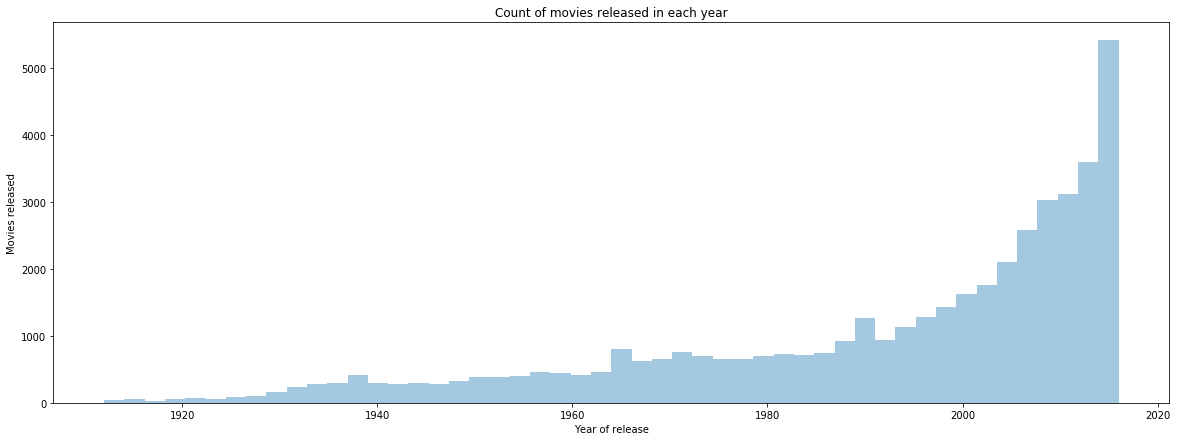

In [8]:
movies_df = movies_raw_df.copy()

# After inspections in df we found duplicated rows so we'll drop the to keep unique values
duplications = len(movies_df['id']) - len(movies_df.drop_duplicates(['id']))
print( 'REMOVED: {} duplicates'.format(duplications) )
movies_df.drop_duplicates(['id'],inplace=True)

# create a new column with the release year
movies_df['release_year'] = pd.to_datetime(movies_df['release_date'],errors='coerce').dt.year.fillna(0)
print( 'REMOVED: {} movies without release year'.format(len(movies_df[ movies_df['release_year'] == 0 ])) )
movies_df = movies_df[ movies_df['release_year'] != 0 ]

# clearing popularity column
movies_df['popularity'] = pd.to_numeric(movies_df['popularity'],errors='coerce')
print( 'REMOVED: {} movies without popularity'.format(len(movies_df[ movies_df['popularity'] == 0 ])) )
movies_df = movies_df[ movies_df['popularity'] != 0 ]

# Remove unreleased films
print( 'REMOVED: {} movies that not released yet'.format(len(movies_df[ movies_df['status'] != 'Released' ])) )
movies_df = movies_df[ movies_df['status'] == 'Released' ]

# finding the longest sequence of years with movie count higher then 10
def find_movies_range(df, threshold):
    # group by year
    groupby_year = df.groupby('release_year').size().reset_index(name='count').sort_values(['release_year'])
    # for each year, if it has sufficient number of movies
    groupby_year['count'] = groupby_year['count'].apply(lambda x: x < threshold)
    groupby_year.reset_index(inplace=True)
    # search for sequence of years with 10 >= movies
    groupby_year = groupby_year.groupby(groupby_year['count'].cumsum()).agg(
        {'release_year':['count', 'min', 'max']})
    groupby_year.columns = groupby_year.columns.droplevel()
    # get the longest year sequence in the dataset
    return groupby_year[groupby_year['count']==groupby_year['count'].max()]

years_range = find_movies_range( movies_df, 10 )

# clean movies out of limit
movies_df = movies_df[(movies_df['release_year'] > int(years_range['min'].values)) & (movies_df['release_year'] < int(years_range['max'].values))]

print('Cleaning anomalies years, we are left with {} to {}'.format(
    int(years_range['min'].values),int(years_range['max'].values))
)    


"""
Preparing our genres column for usage
Genres are stored as JSONs in our dataset, lets convert to it to hot-one format
"""
def genre_json_to_hotone( df ):
    genres_list = set()
    for index, row in df.iterrows():
        # extract genres
        movies_genres = ast.literal_eval(row['genres'])
        for genre in movies_genres:
            # if genre is not a column, generate the column and set all to 0
            if genre['name'] not in df:
                genres_list.add(genre['name'])
                df[ genre['name'] ] = 0
            df.at[index, genre['name']] = 1
    return genres_list

genres_list = genre_json_to_hotone( movies_df )

# removing unnecessary columns
movies_df.drop(['imdb_id','homepage','adult','belongs_to_collection','production_countries','overview','tagline',
                'video', 'genres','poster_path', 'spoken_languages','status'],inplace=True,axis=1)    

# Get a feeling of the movies and their release year
f, axes = plt.subplots(figsize=(20, 7))
sns.distplot(movies_df['release_year'], ax=axes, kde=False)
plt.xlabel('Year of release')
plt.ylabel('Movies released')
plt.title('Count of movies released in each year')
plt.show()

### Lets look at at the movies's genres

Popularity of movie genres can tell us a lot. in the following segment we will present how many movies in each genre were released each year.

Lets first look how many movies in each genre were released in relation to all movies released in that year.
As a movie can be considered in multiple genres, for our purposes if a movie has 3 genres, then all three are counted.

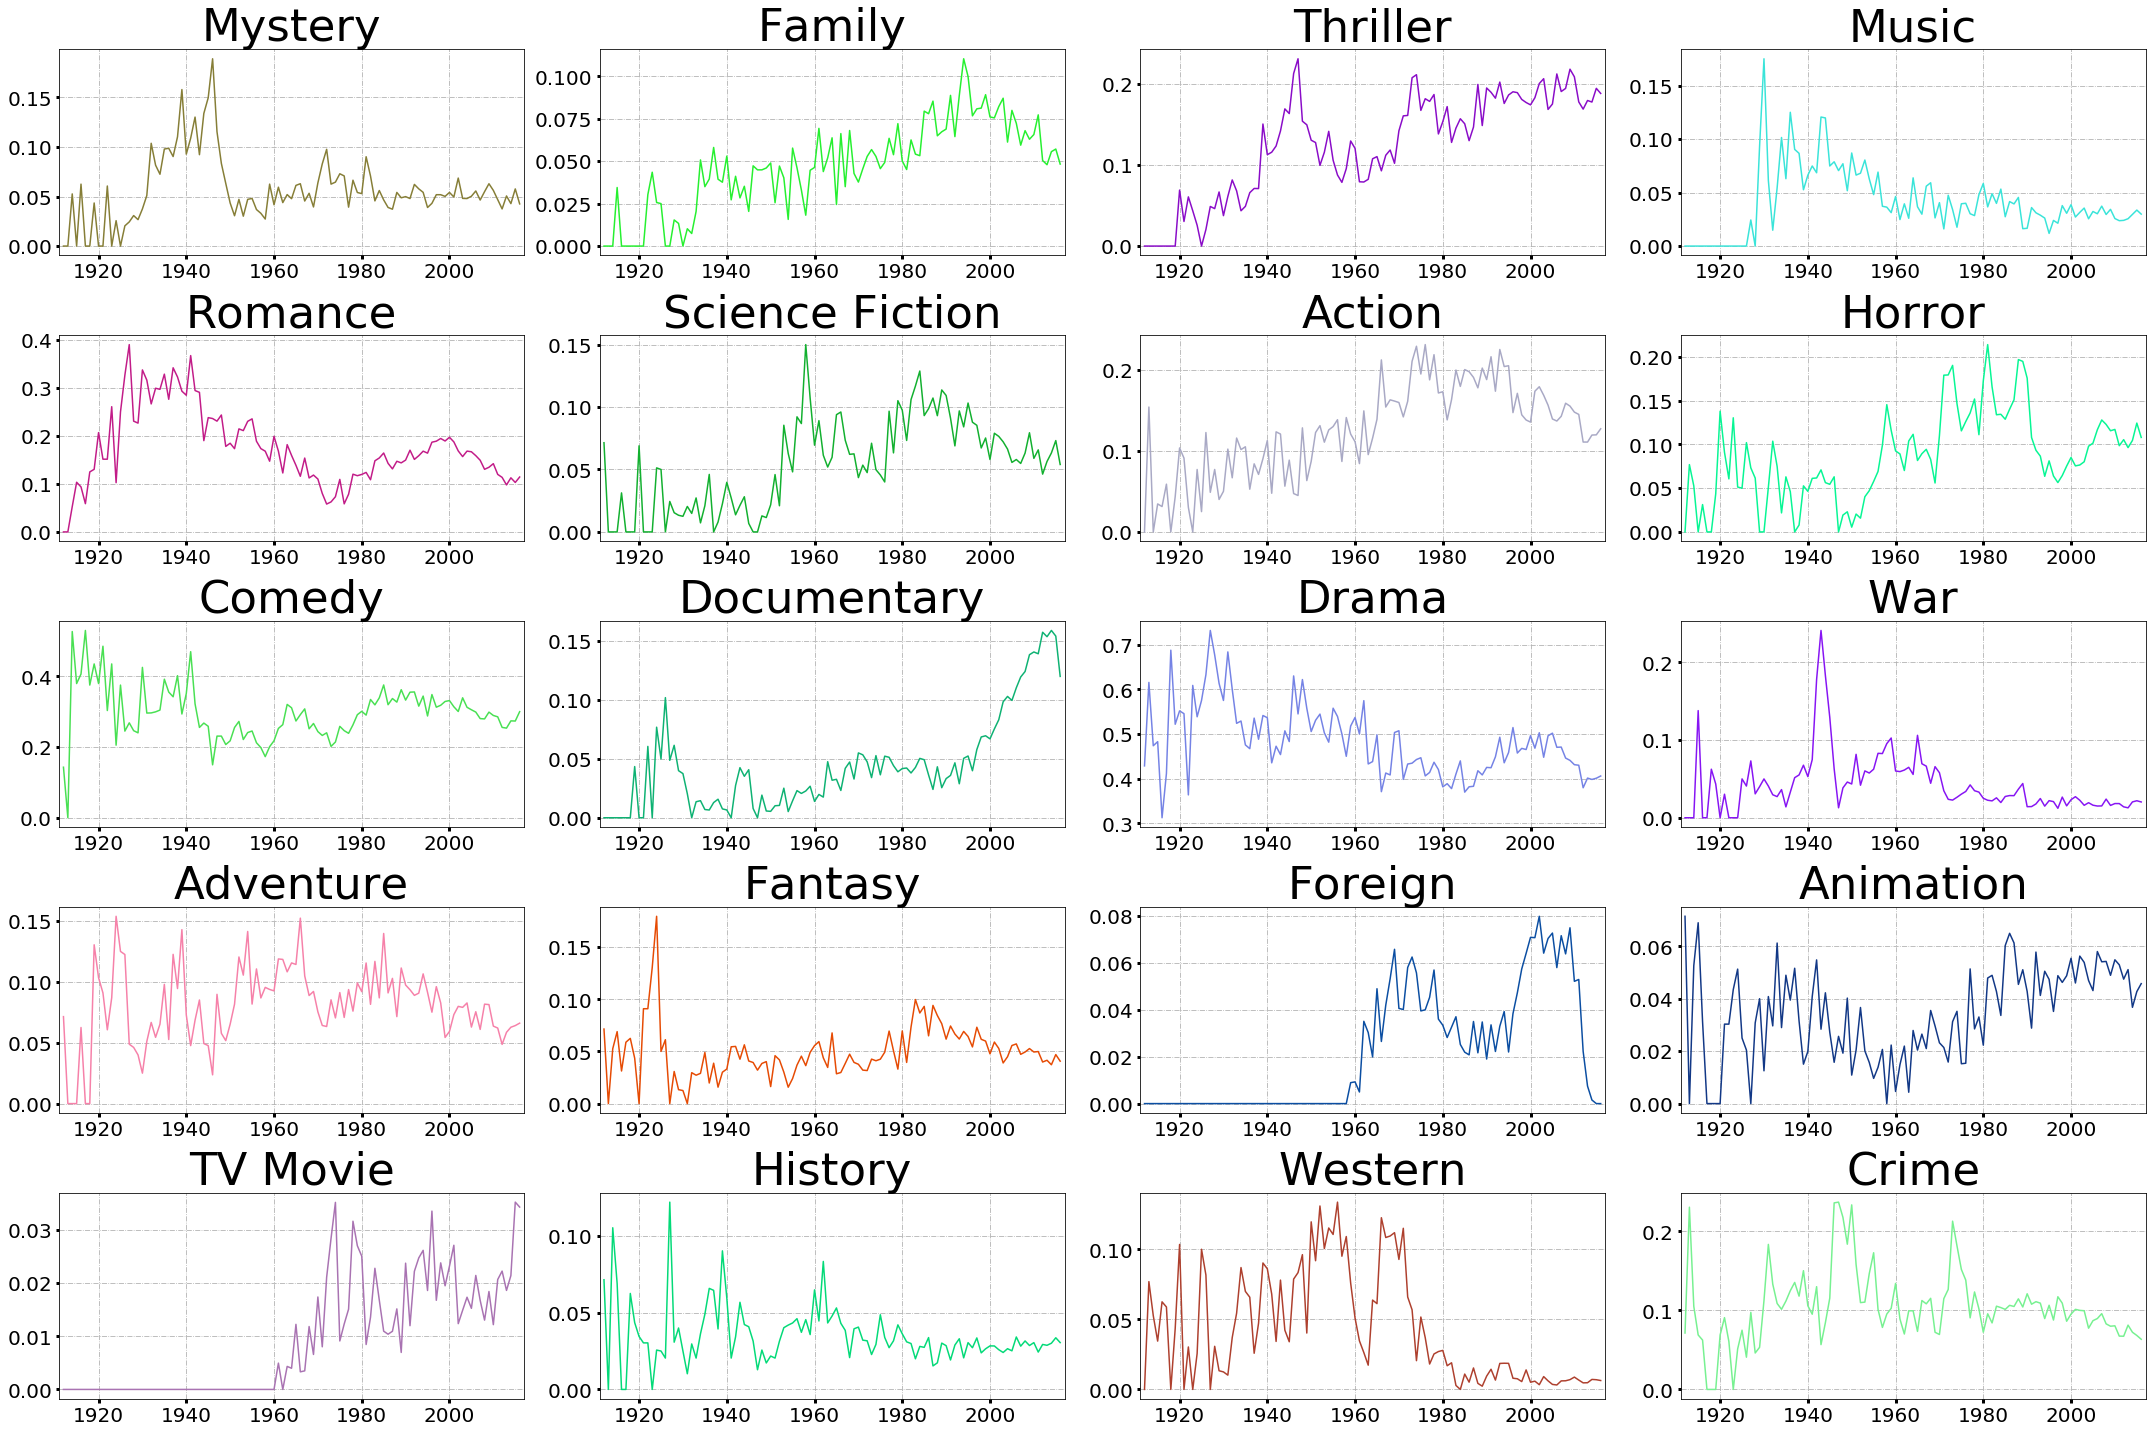

In [4]:
i = 1
fig, axes = plt.subplots(figsize=(30,20))

for genre in genres_list:
    ax = plt.subplot(5,4,i)
    
    d = movies_df[movies_df[genre] == 1].groupby(['release_year',genre]).size().to_frame('count').reset_index()
    d = d.set_index('release_year').drop(genre,axis=1)['count'] / movies_df.groupby('release_year').size()
    d.fillna(0,inplace=True)
    
    sns.lineplot(data=d,color=np.random.rand(3,))
    
    ax.grid(True, linestyle='-.')
    ax.tick_params(labelsize=20, width=3)
    plt.ylabel('')
    plt.xlabel('')
    # plt.ylim(bottom=0,top=1)
    plt.xlim(left=years_range['min'].values,right=years_range['max'].values)
    plt.title(genre, {'size' : '45'})
    i+=1
    
plt.tight_layout()
plt.show()

Combining the count of movies released in each year with the following plot, which is showing the median popularity of each 
movie genre in each year we can notice for some intersting insights

#### Some of the insights we can come across while understanding the plots:

- Steady disappearance of Westerns.
- Burst of Musicals on to the scene in the mid-1920s. Then declining since the 1970s.
- Link between Film-Noir and WW2?
- Dwindling popularity of Romance and Action in recent years.
- Increasing popularity of documentaries since the mid 90s.
- Slow increase in popularity of Horror and Thrillers since the 1950s.
- Increase of TV movies as TVs were introduced in the 1940s

This will allow us to tell, in a given year and a genre the propability it will be popular

### What do we consider a recommended movie?

We will consider a movie recommended if he have a weighted rate above average. this movie will have a higher probability of being liked by the average audience.

#### Normalizing our ratings

[based on IMDb's formula](https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV#)

> How do you calculate the rank of movies and TV shows on the Top Rated Movies and Top Rated TV Show lists?
The following formula is used to calculate the Top Rated 250 titles. This formula provides a true 'Bayesian estimate', which takes into account the number of votes each title has received, minimum votes required to be on the list, and the mean vote for all titles:

`weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C`

Where:
- R = average for the movie (mean) = (rating)
- v = number of votes for the movie = (votes)
- m = minimum votes required to be listed in the Top Rated list
- C = the mean vote across the whole report

Please be aware that the Top Rated Movies Chart only includes theatrical features: shorts, TV movies, miniseries and documentaries are not included in the Top Rated Movies Chart. The Top Rated TV Shows Chart includes TV Series, but not TV episodes or Movies.

In [5]:
def calculate_weighted_rate(row):
    m = movies_df['vote_count'].quantile(0.9)
    c = movies_df['vote_average'].mean()
    v = row['vote_count']
    r = row['vote_average']
    res = (v / (v+m)) * r + (m / (v+m)) * c
    return res

movies_df['weighted_rate'] = movies_df.apply(calculate_weighted_rate,axis=1)

movies_df[['original_title','vote_average','weighted_rate']].head()

,original_title,vote_average,weighted_rate
0,Toy Story,7.7,7.639919
1,Jumanji,6.9,6.820204
2,Grumpier Old Men,6.5,5.946166
3,Waiting to Exhale,6.1,5.712889
4,Father of the Bride Part II,5.7,5.666944


In [6]:
# the recommended film column based on mean
wr_mean = movies_df['weighted_rate'].mean()

# drop the columns that weight rate is based on them
movies_df['recommended'] = movies_df.apply(lambda x: 'True' if x['weighted_rate']>=wr_mean else 'False' ,axis=1)
movies_df.head()

,budget,id,original_language,original_title,popularity,production_companies,release_date,revenue,runtime,title,...,Science Fiction,Mystery,War,Foreign,Music,Documentary,Western,TV Movie,weighted_rate,recommended
0,30000000,862,en,Toy Story,21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]",30/10/1995,373554033,81.0,Toy Story,...,0,0,0,0,0,0,0,0,7.639919,True
1,65000000,8844,en,Jumanji,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",15/12/1995,262797249,104.0,Jumanji,...,0,0,0,0,0,0,0,0,6.820204,True
2,0,15602,en,Grumpier Old Men,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",22/12/1995,0,101.0,Grumpier Old Men,...,0,0,0,0,0,0,0,0,5.946166,True
3,16000000,31357,en,Waiting to Exhale,3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,22/12/1995,81452156,127.0,Waiting to Exhale,...,0,0,0,0,0,0,0,0,5.712889,False
4,0,11862,en,Father of the Bride Part II,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...",10/02/1995,76578911,106.0,Father of the Bride Part II,...,0,0,0,0,0,0,0,0,5.666944,False


### Lets create a model to try to predict if a movie is recommended

The model will try to predict if a movie will have an above avarage rate just by the runtime, popularity and the movie's genres.

#### Lets train our model

At first the recommendation prediciton will be based on the runtime, popularity and genres columns.

We will use 3 different models, and we will choose the best one.

In [7]:
movies_data_df = movies_df.drop(columns=['id','original_title', 'title','release_date','revenue','budget',
                                         'weighted_rate','vote_average', 'vote_count'])

def combine_features(row):
    feature = row['original_language'] 
    for company in ast.literal_eval(row['production_companies']):
        try:
            feature += " " + company['name']
        except:
            pass
    return feature

movies_data_df["combined_features"] = movies_df.apply(combine_features,axis=1)
movies_data_df["combined_features"].fillna('',inplace=True)
movies_data_df['runtime'].fillna(0,inplace=True)
movies_data_df.drop(columns=['production_companies', 'original_language','combined_features'],inplace=True)
movies_data_df.head()

,popularity,runtime,release_year,Animation,Comedy,Family,Adventure,Fantasy,Romance,Drama,...,History,Science Fiction,Mystery,War,Foreign,Music,Documentary,Western,TV Movie,recommended
0,21.946943,81.0,1995.0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
1,17.015539,104.0,1995.0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,True
2,11.712900,101.0,1995.0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,True
3,3.859495,127.0,1995.0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,False
4,8.387519,106.0,1995.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False


In [8]:
Xs = movies_data_df.drop('recommended',axis=1)
y = movies_data_df['recommended']
X_train,X_test,y_train,y_test = train_test_split(Xs,y,test_size=0.20,random_state=0)
X_train.shape,X_test.shape


ML_models = {}
model_index = ['LR','RF','NN']
model_sklearn = [LogisticRegression(solver='liblinear',random_state=0),
                 RandomForestClassifier(n_estimators=100,random_state=0),
                 MLPClassifier([100]*5,early_stopping=True,learning_rate='adaptive',random_state=0)]

model_summary = []

for name,model in zip(model_index,model_sklearn):
    ML_models[name] = model.fit(X_train,y_train)
    preds = model.predict(X_test)
    model_summary.append([name,f1_score(y_test,preds,average='weighted'),accuracy_score(y_test,preds),
                          roc_auc_score(y_test,model.predict_proba(X_test)[:,1]),])\
    
print(ML_models)

model_summary = pd.DataFrame(model_summary,columns=['Name','F1_score','Accuracy','AUC_ROC'])
model_summary = model_summary.reset_index()
display(model_summary)

{'LR': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), 'RF': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False), 'NN': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, ea

,index,Name,F1_score,Accuracy,AUC_ROC
0,0,LR,0.814021,0.827337,0.864917
1,1,RF,0.842552,0.846458,0.895548
2,2,NN,0.817574,0.829713,0.883772


### Content-based Filtering Summary

We tested 3 different algorithms and found out that the most accurate one to predict a 'recommended movie' is RandomForestClassifier algorithm by looking at the 3 measures.

This is all set by the genres of the film, it's runtime and how popular he was.

##### Finding the optimal paramaters for the most profitable and recommended movie

In the following example, we will find out the optimal spec a movie need to have inorder to be profitble(revenue / budget wise) and to be considered a recommened movie, which is what all movie makers seek for. We will look at the top 1000 recommended and most profitible movies.

Using [median of medians](https://en.wikipedia.org/wiki/Median_of_medians)(The median of medians is a simple approximate selection algorithm) to find the optimal runtime and counting how many movies released in each genre we will produce the optimal formula for a movie.

Optimal runtime is between 96 to 125

The top profitble genres are:
Drama, Comedy, Romance, Action, Adventure

Popularity of those films is between 7 to 14
While the popularity median of all movies is 1.14, with max value being 547.49 and the standard deviation is 5.33

Genres median popularity scatter over the years:


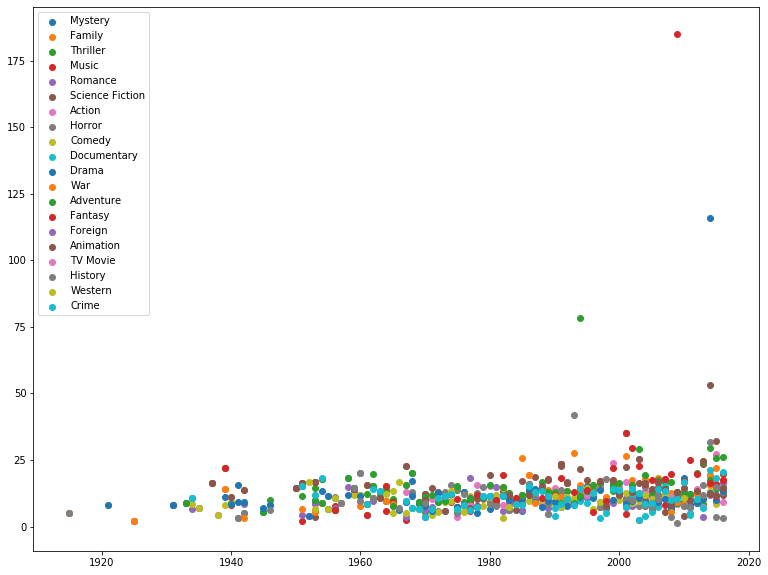

In [9]:
movies_earn_df = movies_df[ \
    ( movies_df['revenue'] > 10**3) & (movies_df['budget'] > 10**3) & (movies_df['recommended'] == 'True') \
    ].copy()

movies_earn_df['r/b'] = movies_earn_df.apply(lambda x: (x['revenue'] / x['budget']),axis=1)
movies_earn_df.sort_values(by=['r/b'],ascending=False,inplace=True)
movies_earn_df.reset_index(inplace=True)
movies_earn_df = movies_earn_df.head(1000)

runtime_opt_range = {
    'min': int(movies_earn_df[ movies_earn_df['runtime'].median() > movies_earn_df['runtime'] ]['runtime'].median()),
    'max': int(movies_earn_df[ movies_earn_df['runtime'].median() < movies_earn_df['runtime'] ]['runtime'].median())
}

print('Optimal runtime is between {} to {}'.format(runtime_opt_range['min'], runtime_opt_range['max']))

genres_count = pd.DataFrame(columns=genres_list,
                            index=np.arange(years_range['min'].values,years_range['max'].values))
genres_popularity_sum = pd.DataFrame(columns=genres_list,
                                    index=np.arange(years_range['min'].values,years_range['max'].values))

fig = plt.figure(figsize=[13,10])
axes = fig.add_subplot()

for genre in genres_list:
    # find size of movies in a genre per year
    genres_count[genre] = movies_earn_df[movies_earn_df[genre] == 1].groupby('release_year').size()    
    # caculate median popularity for each genre and year
    genre_pop = movies_earn_df[movies_earn_df[genre] == 1].groupby('release_year') \
        ['popularity'].median()
    axes.scatter(x=genre_pop.index, y=genre_pop.values, label=genre,)
    
genres_count.fillna(0,inplace=True)
genres_popularity_sum.fillna(0,inplace=True)

print('\nThe top profitble genres are:')
print(*genres_count.max().sort_values(ascending=False).head().index, sep = ", ")

#print(movies_earn_df.iloc[movies_earn_df[movies_earn_df['Mystery'] == 1]['popularity'].idxmax()])
#print(movies_earn_df.iloc[movies_earn_df[movies_earn_df['Fantasy'] == 1]['popularity'].idxmax()])

popularity_range = {
    'min': int(movies_earn_df[ movies_earn_df['popularity'].median() > movies_earn_df['popularity'] ]['popularity'].median()),
    'max': int(movies_earn_df[ movies_earn_df['popularity'].median() < movies_earn_df['popularity'] ]['popularity'].median())
}

print('\nPopularity of those films is between {} to {}'.format(popularity_range['min'], popularity_range['max']))
print('While the popularity median of all movies is {:.2f}, with max value being {:.2f} and the standard deviation is {:.2f}'.format(movies_df['popularity'].median(),movies_df['popularity'].max(),movies_df['popularity'].std()) )

print('\nGenres median popularity scatter over the years:')
plt.legend();
plt.show()

We can notice that expcet for the years 2009 for Fantasy (right after Avatar movie was released) and 2014 for Mystery (Right after the Purge movies started being released) which are anamolies because of their budget and revenue(Avatar broke the recored for the most profitable movie. The first Purge movie budget was 3 million dollars) most of the profitable and recommended movies have a pretty consistant popularity.

We can't control how popular a movie will be, this is up to the audience to decide, but we can see that they are not exteremly more popular than not recommended movies.

---

# Collaborative Filtering

Collaborative filtering is a way recommendation systems filter information by using the preferences of other people.
It uses the assumption that if person A has similar preferences to person B on items they have both reviewed,
then person A is likely to have a similar preference to person B on an item only person B has reviewed.

## Genres Based Recommnder

**Our key goal here will be to understand the users favorite genres or its watching habits based on its ratings, than to recommend a movies based on it.**

Creating a DataFrame with each user's avarage rating for each genre. ratings are between 1 to 5, genres that are not rated we will set the rating to zero.

In [10]:
generes_df = movies_raw_df.loc[:, ('genres', 'title', 'id')]
generes_df.drop_duplicates(['id'], inplace=True)
generes_df.dropna()

# Preparing our genres column for usage
genres_list = genre_json_to_hotone( generes_df )

generes_df.drop(columns=['genres'], inplace=True)
generes_df.set_index('id', inplace=True)

In [11]:
genre_ratings = pd.DataFrame()

for genre in genres_list:
    genre_movies = generes_df[generes_df[genre] == 1]
    avg_genre_votes_per_user = ratings_raw_df[ratings_raw_df['movieId'].isin(genre_movies.index)] \
        .loc[:, ['userId', 'rating']] \
        .groupby(['userId'])['rating'].mean()
    genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
genre_ratings.columns = genres_list

# fill 0 if user didn't rate the genre
genre_ratings.fillna(0,inplace=True)

#### Glance at our data

Now when the data is clean and set for use, As we can see we have 265k users with ratings on 20 genres, We can choose the right clustering methodology.

In [12]:
print(genre_ratings.head(3))

print('\nData size: {}'.format(genre_ratings.shape))

   Mystery  Family  Thriller  Music   Romance  Science Fiction  Action  \
1      1.0     0.0       0.0    0.0  3.333333              0.0    3.50   
2      3.5     1.5       4.0    1.0  4.000000              4.0    3.75   
3      3.0     0.0       2.5    0.0  3.333333              3.0    3.00   

   Horror  Comedy  Documentary  Drama  War  Adventure  Fantasy  Foreign  \
1     0.0    4.25          5.0  4.125  0.0        0.0     0.00      3.5   
2     4.0    2.80          0.0  3.000  3.0        3.5     3.25      0.0   
3     0.0    3.20          0.0  3.400  0.0        0.0     3.00      0.0   

   Animation  TV Movie  History  Western     Crime  
1        0.0       0.0      0.0      0.0  4.500000  
2        0.0       0.0      3.5      0.0  3.000000  
3        0.0       0.0      0.0      0.0  2.666667  

Data size: (265848, 20)


#### Getting a feeling of working with K-Means and our dataset

Let look at a subsample of the users who rated comedy and adventure and search for a correlation between the ratings.

##### Choose number of clusters with the Elbow Method

The elbow method is used for determining the correct number of clusters in a dataset.
we calcualte the Variance ratio which is determined by the variance between groups / total varince 

> It works by plotting the ascending values of K versus the total error obtained when using that K.

In [13]:
# %%timeit
# Lets get only the Pepole who rated movies that related to comedy and adventure genres
comedy_adven_df = genre_ratings[['Comedy','Adventure']]
comedy_adven_df = comedy_adven_df[(comedy_adven_df['Comedy']>=1) & (comedy_adven_df['Adventure']>=1)]

X = comedy_adven_df.sample(int(len(comedy_adven_df)*0.8))

# Choose the range of k values to test.
possible_k_values = range(2, 20,2)

def clustering_errors(k, data):
    print('running on k: {}'.format(k))
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 1.0)

ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')

yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)

ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

running on k: 2
running on k: 4


KeyboardInterrupt: 

###### the number of clusters that was determined is K=7 ????

###### Now lets cluster the two genres and  try to figure out how the users are grouped 

The Methodolgy we choose is KMeans

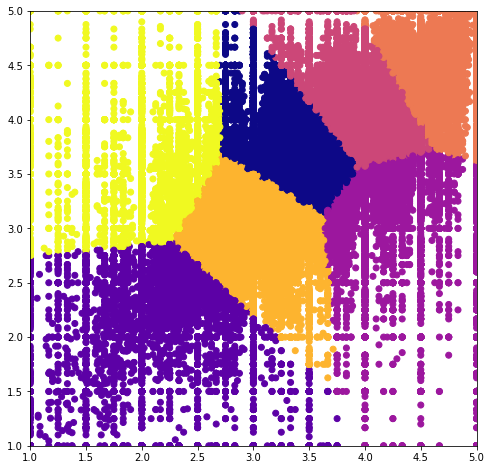

In [15]:
comedy_adven_df = genre_ratings[['Comedy','Adventure']]#.sample(10**4)
comedy_adven_df = comedy_adven_df[(comedy_adven_df['Comedy']>=1) & (comedy_adven_df['Adventure']>=1)]

# TODO: change this number depending on the running
number_clusters = 7

X_comedy_adven = comedy_adven_df.values

# Lets create an object of KMeans and cluster comedy and adventure genres 
kmeans_model = KMeans(n_clusters=number_clusters)
predictions = kmeans_model.fit_predict(X_comedy_adven)

# Defining the cluster
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

plt.xlim(1, 5)
plt.ylim(1, 5)
clustered = pd.concat([genre_ratings.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
plt.scatter(comedy_adven_df['Adventure'],comedy_adven_df['Comedy'],c=predictions, cmap='plasma')

### All Genres Clustering

Lets take an arbitrary k number (k=20) and analyse those clusters to spot certain trends and commonalities in each cluster. After that, we will plot each cluster as a heatmap.

In [16]:
# lets try to take 80% of the data and get some intersting insights
subsample_amount = int(genre_ratings.shape[0]*0.8)
subsample_rated_df = genre_ratings[:subsample_amount]

# 20 clusters are detrmined and reorder the df
model = KMeans(n_clusters=20,random_state=1)
predictions = model.fit_predict(subsample_rated_df)
clustered = pd.concat([subsample_rated_df.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
clustered.rename(columns={"index": "User"},inplace=True)
clustered.set_index("User",inplace=True)
# clustered.drop(columns=['num_of_ratings'],inplace=True)

#### Lets look at our clusters, and identify some interests and insights

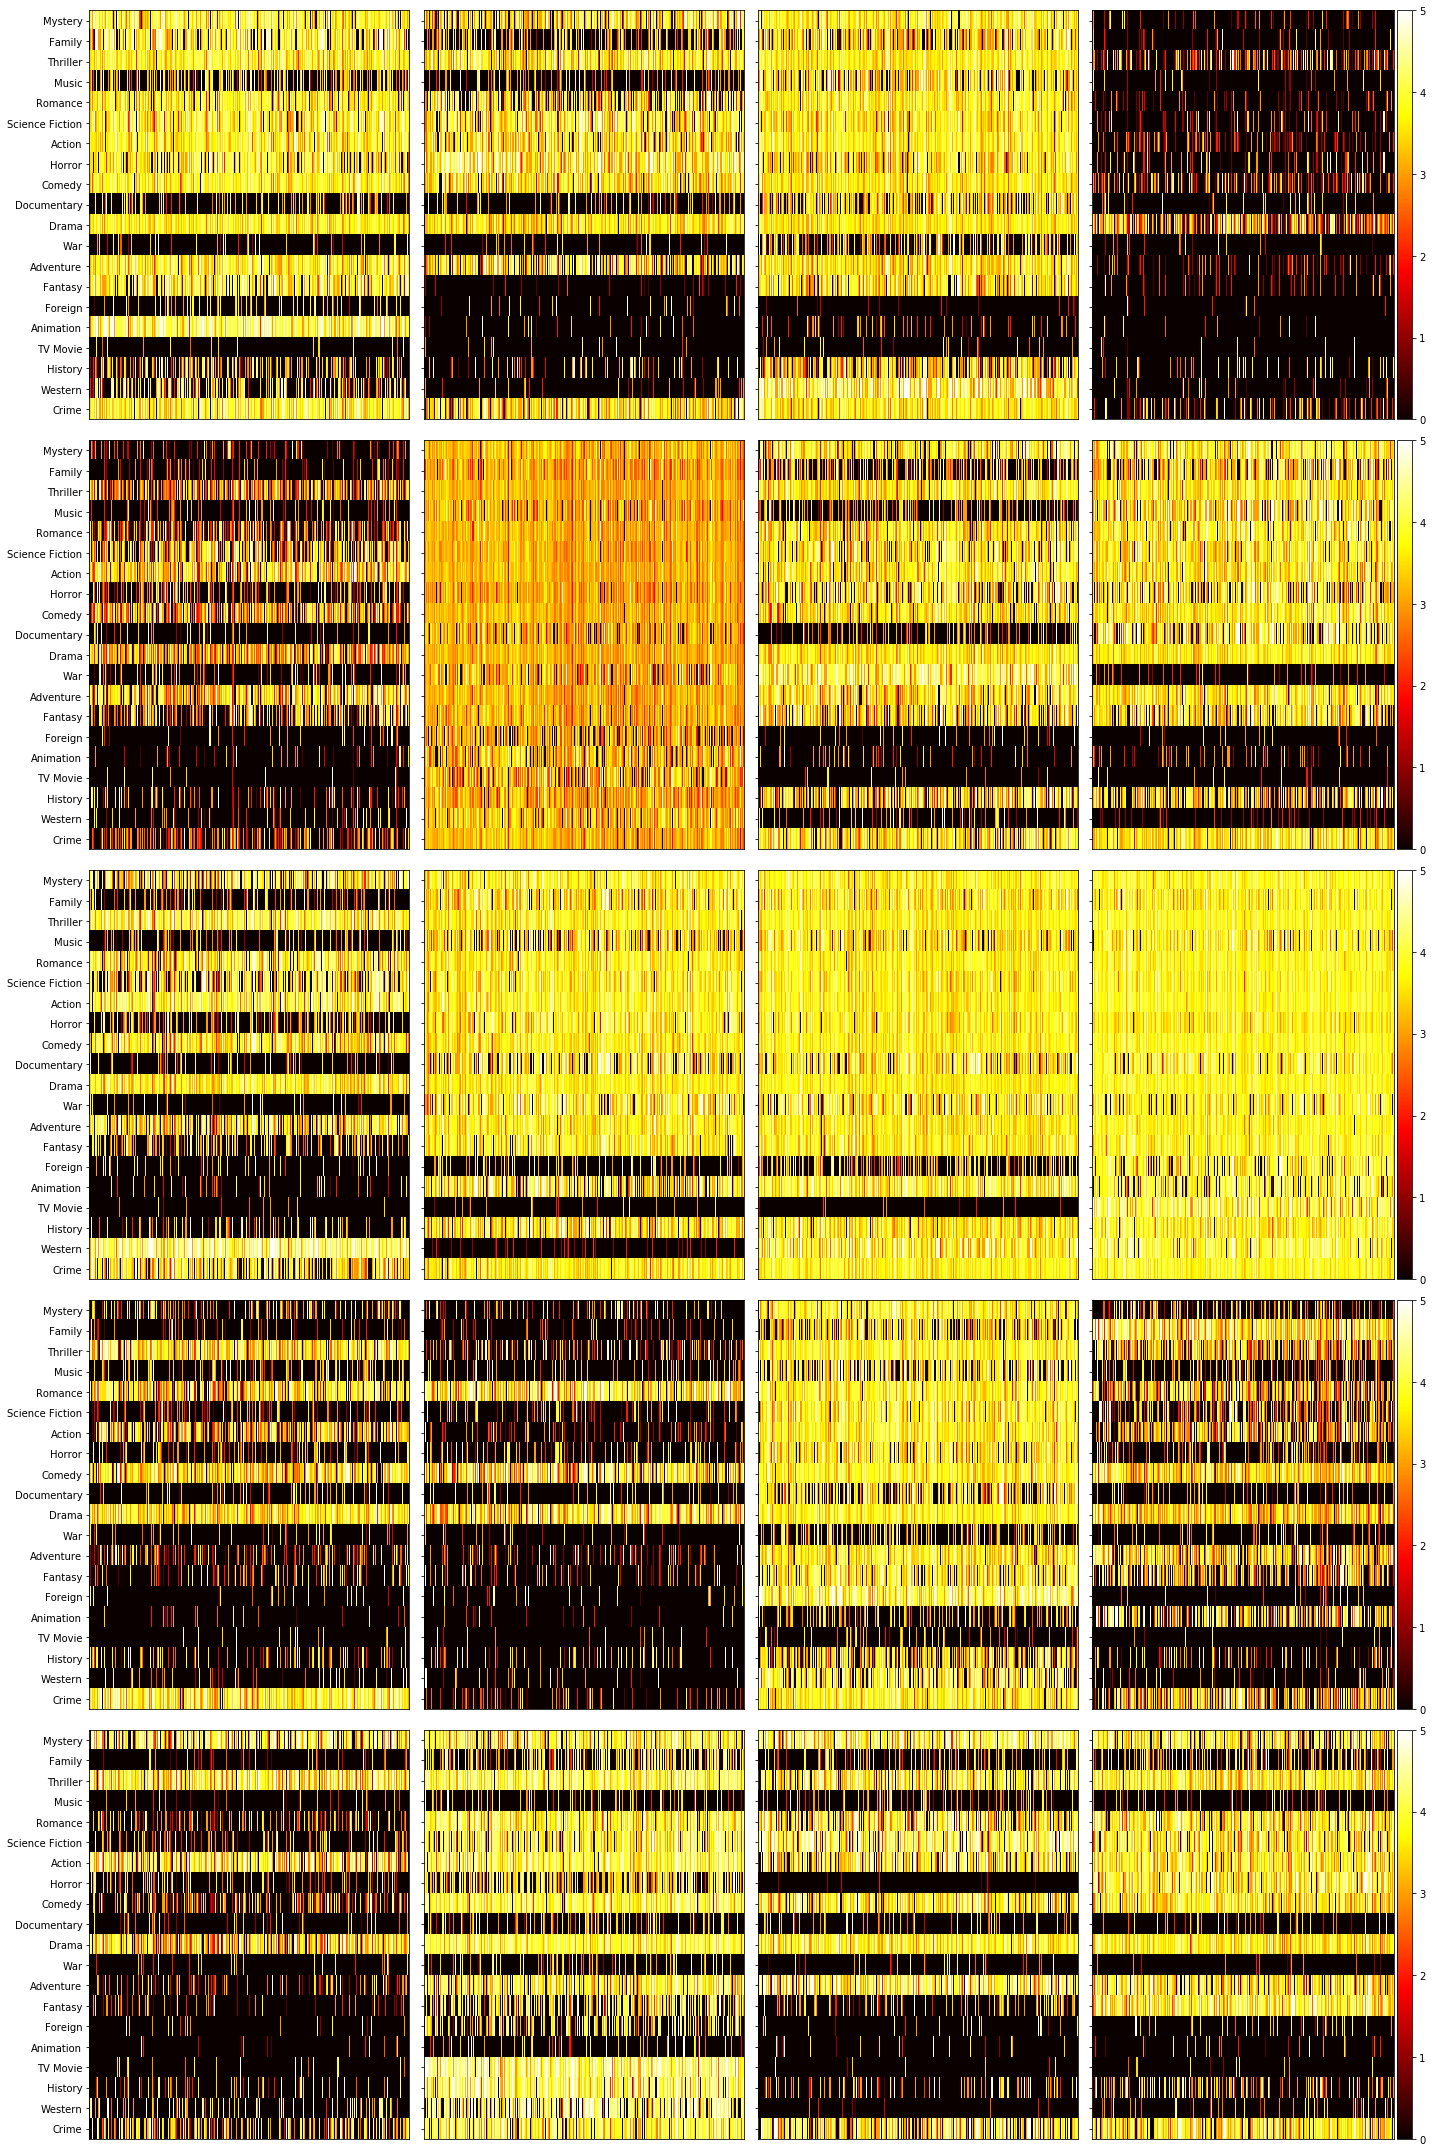

In [17]:
fig, axes = plt.subplots(figsize=(20,30))

for i in range(1,21):
    ax = plt.subplot(5,4,i)
    data = clustered[clustered['group']==(i-1)].copy().drop(columns=['group'])
    heatmap = ax.imshow(data.transpose(), vmin=0, vmax=5, aspect='auto', cmap='hot')

    ax.set_xticks([])
    ax.set_yticks(np.arange(data.shape[1]))

    ax.set_yticklabels([])
    plt.setp(ax.get_xticklabels(), rotation=90)
    
    if( i%4==1 ):
        ax.set_yticklabels(data.columns, minor=False)
        
    if( i%4==0 ):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        # Color bar
        cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
        cbar.ax.set_xticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','no rating'])
    
plt.tight_layout()
plt.show()

###### We can notice specific insights in these heatmaps:

* Some clusters are more sparse, the others maybe really dense. It's  shows us that the model tend to cluster users that have simillar watching habits.  
* Some users tend to watch specif genres and thats it, they dont watch any other genres.
* Vertical lines with the same color correspond to users with low variety in their ratings, they tend to like or dislike most of the movies.
* The more vertical lines of the same color in the cluster, the more similar the ratings will be in that cluster.

# TODO: What are we doing here?

**Lets try to pridect the movies based on it genres, that the user likely to watch**

First lets show 1 of the clusters and try to understand on which genres of its focuses.  
Than lets predict some users and get the users that were related to the specific cluster.  
Watch these users genres ratings.


In [18]:
# ron_movies = [[862,'Toy Story',5],[8844,"Jumanji",2],[94182,"Frozen",5]]
# dani_movies = [[157336,"Interstellar",4.5],[19995,"Avatar",4],[284053,"Thor: Ragnarok",3.5]]

# users = [*ron_movies,*dani_movies]

# custom_df = pd.DataFrame(users, columns =['id','original_title', 'rating'])
# custom_df['genres'] = custom_df.apply(lambda x: \
#                                       str(movies_raw_df.loc[movies_raw_df['id'] == int(x['id'])]['genres'].values),axis=1)


# genres_list = genre_json_to_hotone(custom_df)

# eight_group = clustered[clustered['group']==8]

# cluster = eight_group.mean()
# cluster = cluster.sort_values(ascending=False).drop(labels=['group'])
# print(cluster.head())

# lets get 2 the "test" users so we could predict their clusters and analyze their watching habits.
full_genres_df = genre_ratings.reset_index()
full_genres_df.rename(columns={"index": "user"},inplace=True)

sampled_rated_df = subsample_rated_df.reset_index()
sampled_rated_df.rename(columns={"index": "user"},inplace=True)

sampled_rated_list = list(sampled_rated_df['user'])
test_df = full_genres_df[~(full_genres_df['user'].isin(sampled_rated_list))][:2]
test_df = test_df.set_index('user')

# predict thgeir clusters
test_predictions = model.predict(test_df)

# Lets filter only the users that related to "eight_group" 
preds = pd.concat([test_df.reset_index(), pd.DataFrame({'cluster':test_predictions})], axis=1)
# preds = preds[preds['cluster']==8].drop(columns=['cluster','user'])
preds = preds.mean().sort_values(ascending=False)

# Now lets watch what we have predicted
print(preds)


user               216710.500000
cluster                 6.500000
Crime                   3.850000
Comedy                  3.785714
Fantasy                 3.500000
Horror                  3.500000
Drama                   3.187500
Romance                 3.187500
Science Fiction         2.500000
Adventure               2.458333
Animation               2.375000
Action                  2.166667
Thriller                2.000000
History                 2.000000
Mystery                 1.625000
Family                  1.625000
Foreign                 1.500000
Music                   1.000000
Western                 0.000000
War                     0.000000
TV Movie                0.000000
Documentary             0.000000
dtype: float64


------

## User Based Recommender

This time instead of recommending movies based on the genres the user rated, we will recommend movies by other users rating similar movies.

As we have big dataset of user ratings, we can achieve this recommendation modal easly by finding the correlation between the users rating.

lets prepare our data first.

In [92]:
userIds = np.random.randint(int(ratings_raw_df['userId'].min()),int(ratings_raw_df['userId'].max()),1000)

ratings_df = pd.DataFrame(ratings_raw_df.columns)
ratings_df = ratings_raw_df[ratings_raw_df['userId'].isin(userIds)].copy()

# convert rating timestamp to date
ratings_df['date'] = ratings_df.apply(lambda x: str(datetime.fromtimestamp(x['timestamp']).strftime('%Y-%m-%d')),axis=1)
#extract release year
ratings_df['vote_year'] = pd.to_datetime(ratings_df['date']).dt.year

In the original dataset each user rating was in a new row. After merging the user ratings with the movies dataset(inorder to get the movie title), we will pivot the DF that way we will have in each row a user with his ratings.

#### Get a feeling of the ratings data set

lets check out the movies rating years and the checking the ratings means distributions

movies rating years distributions


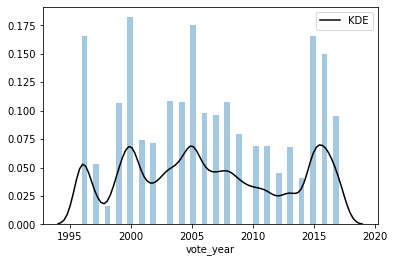

count of ratings


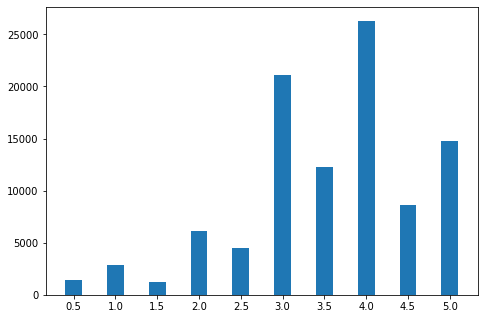

In [93]:
print('movies rating years distributions')
sns.distplot(ratings_df['vote_year'],
                  kde_kws={"color": "k","label": "KDE"})
plt.show()

print('count of ratings')

ratings_count = ratings_df.groupby(by=['rating']).size()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xticks(ratings_count.index, minor=False)
ax.bar(ratings_count.index,ratings_count.values,width=0.2)
plt.show()

We can see that most of the votes are higher than 3, with the most popular vote be 4.

### Compute pairwise correlation of ratings

We will find the correlation between the ratings with Pearson correlation coefficient.

In [103]:
ratings_movies_df = pd.merge(movies_df,ratings_df,
                             how="left", left_on='id', right_on='movieId') \
                            .loc[:, ('movieId','title','userId','rating')]

# remove movies with less then 10 ratings
user_ratings_df = ratings_movies_df.pivot_table(index=['userId'],columns=['title'],values='rating')
user_ratings_df = user_ratings_df.dropna(thresh=5, axis=1).fillna(0,axis=1)

print(user_ratings_df.shape)

In [105]:
corr_matrix = user_ratings_df.corr(method='pearson')
corr_matrix.head(10)

title,10 Items or Less,10 Things I Hate About You,1984,2 Days in Paris,"20,000 Leagues Under the Sea",2001: A Space Odyssey,2010,24 Hour Party People,25th Hour,28 Days Later,...,Yella,Yesterday,You Only Live Twice,Young Adam,Young Frankenstein,Young and Innocent,Z,Zatoichi,xXx,À nos amours
title,,,,,,,,,,,,,,,,,,,,,
10 Items or Less,1.000000,-0.007758,-0.007821,-0.011087,0.064924,0.044309,-0.007197,0.035315,-0.012084,-0.020669,...,-0.011800,0.006353,-0.006798,-0.018175,-0.015705,0.065417,-0.007332,0.053344,-0.017911,0.190500
10 Things I Hate About You,-0.007758,1.000000,-0.006159,0.133265,0.096992,0.053493,-0.005668,-0.008908,-0.009517,0.043218,...,-0.009293,0.043000,-0.005354,0.055417,0.101984,0.069530,-0.005774,0.044613,-0.014106,0.105806
1984,-0.007821,-0.006159,1.000000,0.108438,0.022821,0.094661,0.162518,0.502205,0.126708,0.080814,...,0.156663,-0.002113,-0.005397,0.144193,0.008185,0.085131,-0.005821,-0.014040,-0.014220,0.254970
2 Days in Paris,-0.011087,0.133265,0.108438,1.000000,0.193325,0.094622,-0.008100,0.094363,0.089913,0.014044,...,0.056892,0.054529,-0.007651,0.156226,0.061198,0.102366,-0.008252,0.137632,-0.020159,0.227476
"20,000 Leagues Under the Sea",0.064924,0.096992,0.022821,0.193325,1.000000,0.136730,0.090859,0.088393,0.116067,0.260923,...,0.094884,0.225121,0.055916,0.202567,0.162492,0.198529,0.079762,0.074959,0.085201,0.155754
2001: A Space Odyssey,0.044309,0.053493,0.094661,0.094622,0.136730,1.000000,0.000011,0.096762,0.069849,0.055609,...,0.033334,0.051843,0.027421,0.324448,0.053908,0.058386,0.023900,0.102284,0.013412,0.092420
2010,-0.007197,-0.005668,0.162518,-0.008100,0.090859,0.000011,1.000000,-0.008264,-0.008828,0.057762,...,-0.008621,0.055522,-0.004967,-0.013278,-0.011473,0.099588,0.034072,-0.005239,0.009296,-0.001190
24 Hour Party People,0.035315,-0.008908,0.502205,0.094363,0.088393,0.096762,-0.008264,1.000000,0.095067,0.004896,...,0.228780,-0.007483,-0.007806,0.152870,0.014983,0.076271,0.074206,-0.020306,0.010214,0.277314
25th Hour,-0.012084,-0.009517,0.126708,0.089913,0.116067,0.069849,-0.008828,0.095067,1.000000,0.052918,...,0.074754,-0.010868,0.049975,0.035800,0.122058,0.060958,-0.008994,0.024983,0.019680,0.078545


Now that we have the correlation between movies based on the users rating, we will try to recommoned a movie.

Each user rating will be normalized by subtracting 2.5 from the user's rating, that way if the it has a low rating it will be a negative number and will not be recommended. Then we will sort by the result of the multiplication in present the highest results.

#### Now lets check what we get

Lets take Ron for example, he likes action movies especially Batman, but doesn't like old fashion action

In [153]:
def get_similar(movie_name,rating):
    similar_ratings = corr_matrix[movie_name]*(rating-2.5)
    similar_ratings = similar_ratings.sort_values(ascending=False)
    return similar_ratings

rons_movies = [
    ("Rocky",2),
    ("Die Hard",3),
    ("2010", 2),
    ("Batman Begins",5),
    ("Mission: Impossible",4)]

similar_movies = pd.DataFrame()
for movie,rating in rons_movies:
    similar_movies = similar_movies.append(get_similar(movie,rating),ignore_index = True)

similar_movies.head(10)

,10 Items or Less,10 Things I Hate About You,1984,2 Days in Paris,"20,000 Leagues Under the Sea",2001: A Space Odyssey,2010,24 Hour Party People,25th Hour,28 Days Later,...,Yella,Yesterday,You Only Live Twice,Young Adam,Young Frankenstein,Young and Innocent,Z,Zatoichi,xXx,À nos amours
0,0.004912,-0.070306,-0.139639,-0.038075,-0.010149,-0.124856,0.003589,-0.168744,-0.053116,-0.011008,...,-0.056760,0.012566,0.003390,-0.072509,-0.057716,-0.066407,0.003656,-0.012154,0.008932,-0.059550
1,0.039962,0.092592,0.103311,0.096572,0.039826,0.046293,0.079384,0.126225,0.050618,0.037897,...,0.030515,0.022574,-0.005358,0.044649,0.003244,0.062193,0.076896,0.066039,0.086016,0.149717
2,0.003598,0.002834,-0.081259,0.004050,-0.045430,-0.000005,-0.500000,0.004132,0.004414,-0.028881,...,0.004310,-0.027761,0.002483,0.006639,0.005737,-0.049794,-0.017036,0.002619,-0.004648,0.000595
3,0.018313,0.178602,0.239707,0.226504,0.348328,0.271951,-0.030574,0.442778,0.353502,0.251623,...,0.639549,0.028023,0.095673,0.718192,0.405047,0.118567,0.147960,0.348579,-0.009369,0.305791
4,0.024124,0.096296,0.150681,0.117496,0.230023,0.227693,0.284374,0.142129,0.049495,0.142190,...,0.164681,0.147025,-0.016355,0.090827,0.224353,0.229024,0.244543,0.096759,0.082908,0.227591


In [154]:
similar_movies.sum().sort_values(ascending=False).head(20)

Batman Begins             2.734897
Mission: Impossible       1.738375
Carry On Screaming        1.310381
My Own Private Idaho      1.267060
Bringing Up Baby          1.246450
Jaws: The Revenge         1.214849
The Prestige              1.212197
Fort Saganne              1.199034
The Vexxer                1.185446
Rocky V                   1.180800
The War of the Roses      1.140257
Mr. Destiny               1.136935
The Lady Vanishes         1.129263
Mother India              1.125219
Cinderella Man            1.105135
Mission: Impossible II    1.097251
Alien                     1.084968
Madagascar                1.080465
Days of Glory             1.078197
Lethal Weapon 3           1.071330
dtype: float64

----

# Conclusion

We discussed here two typical methods for building a recommender system. 

## conclusion and further research

In order to conclude what we did, let's mention the steps we went through: we started by getting the data of the elections, then we cleaned the unnecessary data from it (tiny parties for example). in that point we realized that it is not enough "meat" to "analyze" the obvious (unquantified though!) correlation between the votes distribution and the socio-economic mode. so we changed the target to quantifie it and then use it for other purposes. such as applying it on each ballot in the country and then we have the power to conclude (somewhat inaccurate) conclusion on every ballot from the data of the elections to throw it on the state of socio-economic variance for example. because we now have socio-economic ranking for each ballot rather than just have socio-economic ranking for each city!

so we wanted to visualize the primal data to see what is going on under the carpet. we used PCA to plot it and K-MEANS basic analysis to understand it. we also tried to visualize the correlation using basic correlation heat-map. then, we wanted to apply basic ML models to learn the socio-economic-ranking exactly from the elections votes. we applied several models in order to learn them by doing them for our first time and also because didn't have enough intuition of whom will be the best. in that point, we decided to discrete the data into deciles because the relation between the socio-economic ranking and the votes is somewhat inaccurate or not totally attached. the deciles are still a significant division of course. we used SVM (both classifier and regressor), Random-Forest, KNN (both classifier and regressor) and simple Neural Network that didn't work so well (we invested not-long time on each model in order to use many, so the NN was definitely big on us in that terms) the SVM classifier did the best, having a fight with the KNN-Classifier (using basic 75/25 learn/test evaluation), so we took it's results and figured some conclusions(in form of data tables) from it.

the files we are exporting are very interesting outcomes! socio-economic cities- variance are very important information. also, each ballot ranking is interesting (this is actually one layer data-type above the variance because it was concluded from it, so it may have more uses).

The results might have serious inaccuracies, but our evaluation shows signs for a good job. so one should not use this synthetic-information for practical uses but can examine it closely and he might find it interesting as much as we do.

It was a great experience (a little challenging of course) for us, we hope this analysis will have more outcomes!